# [HW 9] Loss Shaping, Noise, and Outliers

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Setup random seed
np.random.seed(20)

# Make fonts bold
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

# Classification

Here we define a classification problem where one of the classes is significantly underrepresented in the training data, but present equally in the test data. You will explore the performance of two objective functions in this situation and try a method for overcoming this class imbalance without changing the objective function.

Below we create two classes drawn from separate 2D Gaussian distributions and with labels $y_i \in \{-1, 1\}$. In the training data class 2 only has 50 samples out of 2050 total, but in the test data both classes have 5000 samples.

In [2]:
def visualize_dataset(X, y, title=""):
    props = {'fontweight': 'bold'}
    if title:
        plt.title(title, **props)
    plt.scatter(X[y < 0.0, 0], X[y < 0.0, 1], s=10)
    plt.scatter(X[y > 0.0, 0], X[y > 0.0, 1], s=10)
    plt.show()

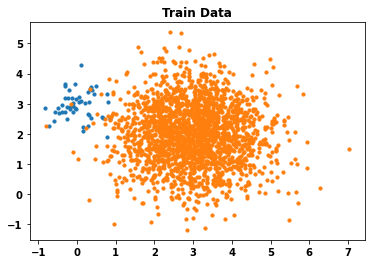

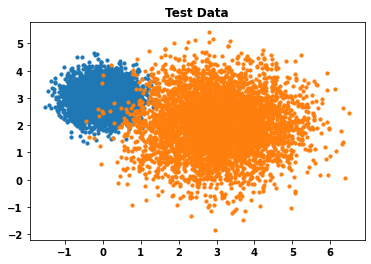

In [3]:
### Generate Train Data
N_1 = 2000
mean_1 = [3.0, 2.0]
cov_1 = [[1, 0.0], [0.0, 1]]
X_1 = np.random.multivariate_normal(mean_1, cov_1, N_1)
y_1 = np.ones(N_1)

N_2 = 50
mean_2 = [0.0, 3.0]
cov_2 = [[0.2, 0.0], [0.0, 0.2]]
X_2 = np.random.multivariate_normal(mean_2, cov_2, N_2)
y_2 = -1.0 * np.ones(N_2)

X_train = np.concatenate((X_1, X_2), axis=0)
Y_train = np.concatenate((y_1, y_2), axis=0)
# Augment X_train with an extra feature (all equals to 1)
X_train_aug = np.ones((X_train.shape[0], X_train.shape[1]+1))
X_train_aug[:,:-1] = X_train


### Generate Train/Test Data
N_test_1 = 5000
X_test_1 = np.random.multivariate_normal(mean_1, cov_1, N_test_1)
y_test_1 = np.ones(N_test_1)

N_test_2 = 5000
X_test_2 = np.random.multivariate_normal(mean_2, cov_2, N_test_2)
y_test_2 = -1.0 * np.ones(N_test_2)

X_test = np.concatenate((X_test_1, X_test_2), axis=0)
Y_test = np.concatenate((y_test_1, y_test_2), axis=0)
# Augment X_test with an extra feature (all equals to 1)
X_test_aug = np.ones((X_test.shape[0], X_test.shape[1]+1))
X_test_aug[:,:-1] = X_test

N_test = N_test_1 + N_test_2

# Visualize the train dataset
visualize_dataset(X_train, Y_train, "Train Data")

# Visualize the test dataset
visualize_dataset(X_test, Y_test, "Test Data")

In [4]:
# Visualize the decision boundary
XX, YY = np.meshgrid(np.linspace(-8.0, 8.0, 500), np.linspace(-8.0, 8.0, 500))
X_vis = np.stack([np.ravel(XX), np.ravel(YY)])
X_vis_aug = np.ones((X_vis.shape[0]+1, X_vis.shape[1]))
X_vis_aug[:-1,:] = X_vis
X_vis_aug = X_vis_aug.T

def visualize_classifier(ys):
    """Visualize the decision boundary for a classifier.
    
    Input: a vector of classification decisions using X0_aug as the samples
    """
    props = {'fontweight': 'bold'}
    ZZ = np.resize(ys, (500, 500))
    # Train
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_title("Train Data with Boundary", **props)
    ax.contourf(XX,YY,ZZ, cmap="coolwarm", levels=np.linspace(-1000,1000,3))
    ax.scatter(X_train[:,0], X_train[:,1], c=Y_train, cmap="coolwarm", s=10)
    ax.axis("equal")
    
    # Test
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_title("Test Data with Boundary", **props)
    ax.contourf(XX,YY,ZZ, cmap="coolwarm", levels=np.linspace(-1000,1000,3))
    ax.scatter(X_test[:,0], X_test[:,1], c=Y_test, cmap="coolwarm", s=10)
    ax.axis("equal")

## Mean Squared Error Loss

We will tackle this problem first with linear least-squares regression, which you have seen many times before.
## (a)
**Using `X_train_aug`, `Y_train`, `X_test_aug`, and `Y_test` perform least-squares regression and report the prediction accuracy on the test set.** `X_*_aug` variables are $\mathbf{X}$ samples augmented with the ones feature to allow the decision hyperplane to be offset from the origin.

In [5]:
def classifier_linear(Xtest, w1):
    """Classify the samples Xtest using weights w1."""
    return -1.0*(Xtest.dot(w1) < 0.0) + 1.0*(Xtest.dot(w1) > 0.0)

In [6]:
# TODO: Perform linear regression on the training data X_train_aug. Report the prediction accuracy with X_test_aug.
### start mse_train ###
w1 = np.linalg.solve(np.dot(X_train_aug.T, X_train_aug), np.dot(X_train_aug.T, Y_train))
### end mse_train ###

# Report the classification accuracy on the test set
ypred = classifier_linear(X_test_aug, w1)
print("prediction accuracy on the test set is ", 1.0*sum(ypred == Y_test) / N_test)


prediction accuracy on the test set is  0.5


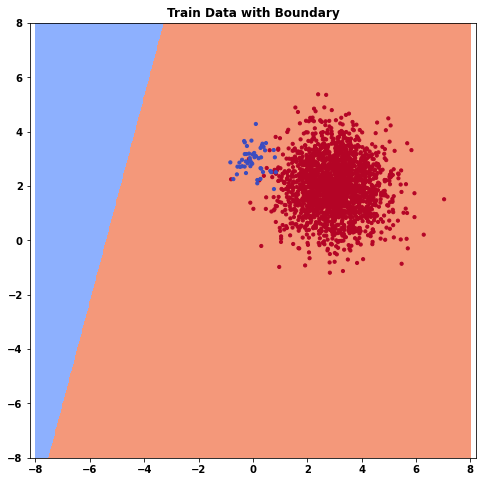

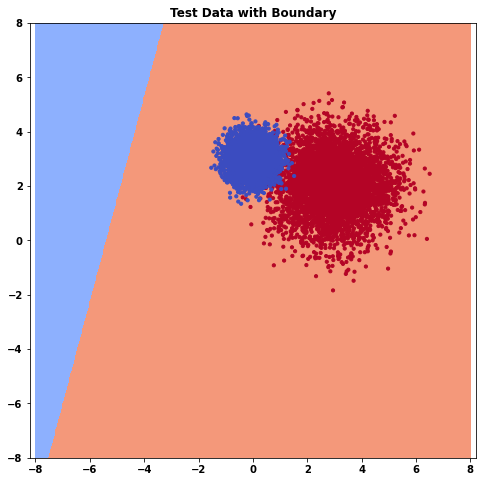

In [7]:
# Map the decision boundary with classifier_linear() and X_vis_aug, 
# then plot the boundary with visualize_classifier()
y0 = classifier_linear(X_vis_aug, w1)
visualize_classifier(y0)

## (b)
**Train on a dataset with copies of the underrepresented class, report prediction error, and visualize the decision boundary.** _Don't forget to show the equivalence in the PDF._

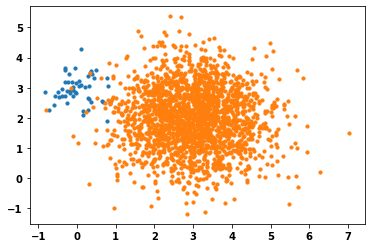

prediction accuracy on the test set is  0.9707


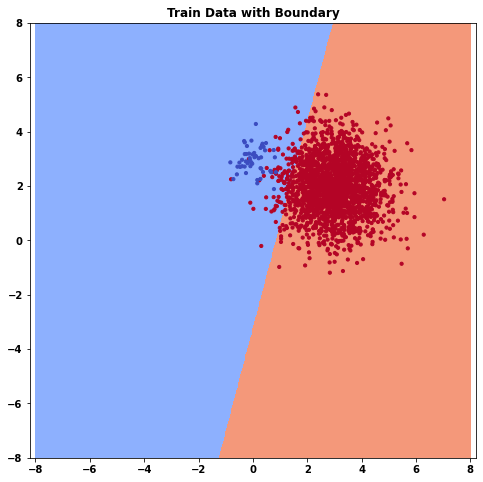

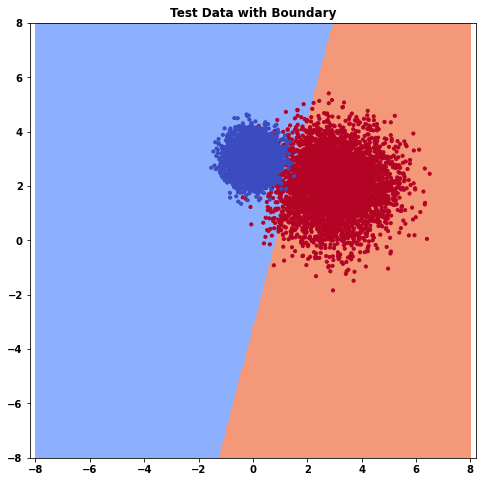

In [8]:
# TODO: Use copies of the underrepresented class to improve performance, 
#       report accuracy, and visualize the decision boundary.
### start mse_copies ###
# Generate new training data with repeat items
k_repeat = int(N_1/N_2)
X_2_repeat = np.repeat(X_2, k_repeat, axis=0)
y_2_repeat = -1.0 * np.ones(X_2_repeat.shape[0])

X_train_repeat = np.concatenate((X_1, X_2_repeat), axis=0)
X_train_repeat_aug = np.ones((X_train_repeat.shape[0], X_train_repeat.shape[1]+1))
X_train_repeat_aug[:,:-1] = X_train_repeat
Y_train_repeat = np.concatenate((y_1, y_2_repeat), axis=0)

# Visualize the repeat train dataset
visualize_dataset(X_train, Y_train)

# Solve the linear regression on the training data
w1 = np.linalg.solve(np.dot(X_train_repeat_aug.T, X_train_repeat_aug), np.dot(X_train_repeat_aug.T, Y_train_repeat))

# Report the classification accuracy on the test set
ypred = -1.0*(X_test_aug.dot(w1) < 0.0) + 1.0*(X_test_aug.dot(w1) > 0.0)
print("prediction accuracy on the test set is ", 1.0*sum(ypred == Y_test) / N_test)

# Visualize the decision boundary
y0 = classifier_linear(X_vis_aug, w1)
visualize_classifier(y0)
### end mse_copies ###

## (c) Logistic Regression
Now we will try solving the unaugmented problem using logistic regression, where we model the _probability_ that a data point corresponds to class 1:
$$h_\theta(\mathbf{x}_i) = P(y_i=1 | \mathbf{x}_i, \mathbf{\theta}) = \frac{1}{1 + e^{-\mathbf{x}_i^T \mathbf{\theta}}}.$$ 
This technique is called logistic _regression_ because we are learning a regression model with the probability of membership in a class as the target, rather than a simple yes/no. When we need a hard decision we simply choose the class with the highest probability.

$\theta$ is typically found using maximum likelihood estimation with the log-likelihood
$$\max_\theta \log L(\theta | \mathbf{X}, \mathbf{y}) = \max_\theta \log \left( \prod_{i=1}^N P(y_i | \mathbf{x}_i, \mathbf{\theta}) \right)$$
$$ = \max_\theta \log \left( \prod_{i=1}^N h_\theta(\mathbf{x}_i)^{y_i} (1 - h_\theta(\mathbf{x}_i))^{(1-y_i)} \right)$$
$$ = \max_\theta \sum_{i=1}^N \left(y_i \log h_\theta(\mathbf{x}_i) + (1-y_i) \log (1 - h_\theta(\mathbf{x}_i)) \right).$$
Here we use $\mathbf{y} \in \{0,1\}^N$ rather than $\{-1,1\}^N$ as with the MSE loss. This loss function may be familiar to some of you as the cross-entropy loss. Here we are actually maximizing the log-likelihood, but we could equivalently minimize the negative log-likelihood.

Unfortunately, there is no general closed-form solution to this optimization problem so we will use the solver included with `sklearn` to find our weights $\mathbf{\theta}$. The general usage pattern for `sklearn` models is to create the object, fit the training set, then predict.

```python
my_classifier = LogisticRegression(penalty='none')
my_classifier.fit(training_data, training_labels)
predictions = my_classifier.predict(test_data)
```

**Using the `LogisticRegression` class, train on data both with and without copies and report your test errors.**

LogisticRegression(penalty='none')

prediction accuracy on the test set is  0.934


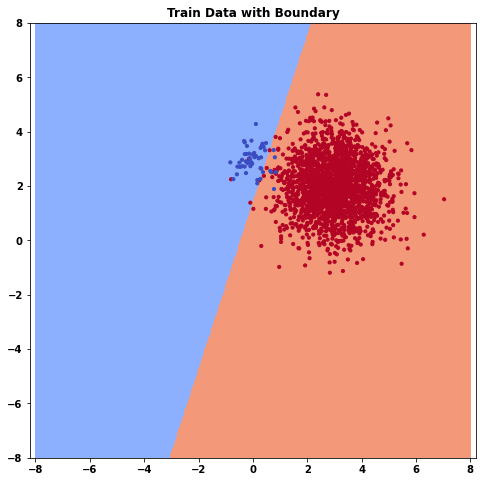

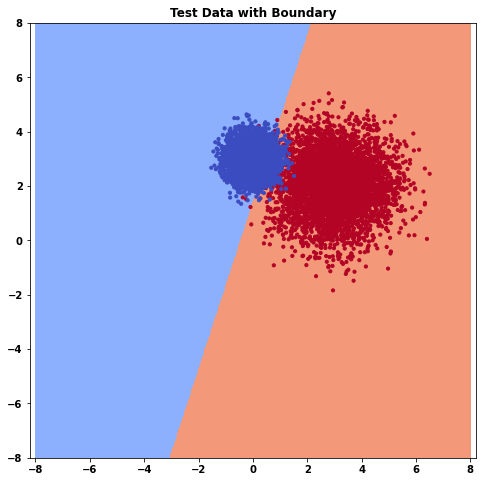

In [9]:
from sklearn.linear_model import LogisticRegression 

# TODO: Train a logistic classifier on the original training data. 
#       Report test accuracy and visualize the decision boundary.
### start logistic ###
classifier_logistic = LogisticRegression(penalty='none')
classifier_logistic.fit(X_train_aug, Y_train)
ypred = classifier_logistic.predict(X_test_aug)
print("prediction accuracy on the test set is ", 1.0*sum(ypred == Y_test) / N_test)

# Test
y0 = classifier_logistic.predict(X_vis_aug)
visualize_classifier(y0)
### end logistic ###

LogisticRegression(penalty='none')

prediction accuracy on the test set is  0.9875


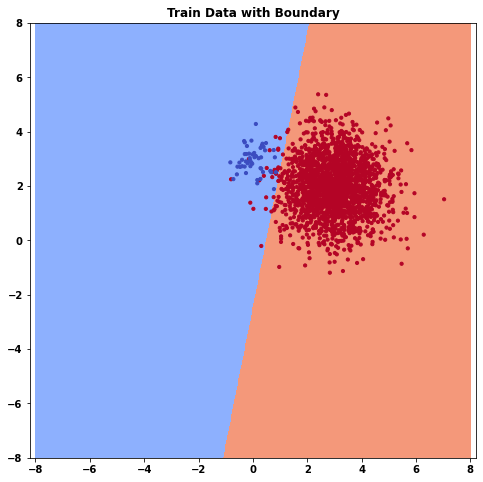

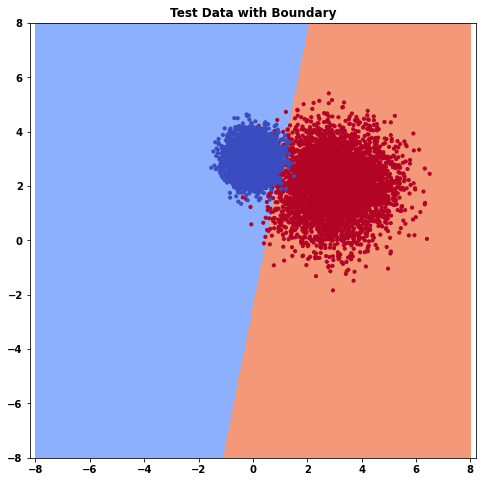

In [10]:
# TODO: Train a logistic classifier on the copy-augmented training data. 
#       Report test accuracy and visualize the decision boundary.
### start logistic_copies ###
classifier_logistic = LogisticRegression(penalty='none')
classifier_logistic.fit(X_train_repeat_aug, Y_train_repeat)
ypred = classifier_logistic.predict(X_test_aug)
print("prediction accuracy on the test set is ", 1.0*sum(ypred == Y_test) / N_test)

# Visualize
y0 = classifier_logistic.predict(X_vis_aug)
visualize_classifier(y0)
### end logistic_copies ###

**Discuss the sensitivity to class imbalance of the two loss functions in your writeup.**

# Regression

There are many loss functions that can be used when performing regression. Each has properties which make it suited to particular situations. There is no 'one size fits all' loss function. We will experiment with different data sets and loss functions to see how they perform below.

## (d) Linear Model with Outliers
We will learn a 1D linear function from data corrupted by additive Gaussian noise and multiplicative outliers.
$$ f(x) = ax + b$$
$$ y = \delta(f(x) + \epsilon),\, \epsilon \sim \mathcal{N}(0, \sigma^2)$$
$$ \delta = \begin{cases} 1&\text{w.p. } p \\ -5&\text{w.p. } 1-p \end{cases}$$

**Train linear models on the data set created below with the $L1$, $L2$, and Huber loss functions.**

In [11]:
def plot_regression(X, y, w_true, model, X_test, loss='Null Loss'):
    if model is None:
        y_hat = np.zeros(X_test.shape[0])
    else:
        y_hat = model.predict(X_test)
    plt.figure(figsize=[10, 6])
    plt.plot(X_test[:, 1], X_test @ w_true, label='True Function')
    plt.scatter(X[:, 1], y, color='darkorange', label='Train Data')
    plt.plot(X_test[:, 1], y_hat, color='darkgreen', linewidth=2, label='Predicted Function')
    plt.xlabel("$x$")
    plt.ylabel("$f(x)$")
    plt.legend()
    true_mse = np.mean((X_test @ w_true - y_hat) ** 2)
    plt.title("%s, True MSE %.2g" % (loss, true_mse), fontweight='bold')

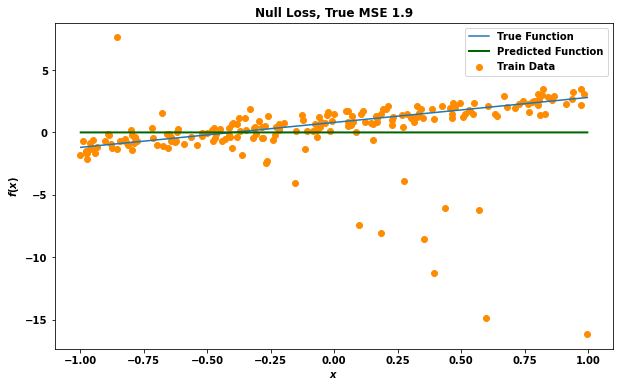

In [12]:
N = 200
X = np.ones((N, 2))
X[:, 1] = np.sort(np.random.uniform(-1, 1, N))
X_test = np.ones((N * 10, 2))
X_test[:, 1] = np.sort(np.random.uniform(-1, 1, N * 10))
w_true = np.array([0.8, 2])
y = X @ w_true + np.random.randn(N) * 0.5

frac_outlier = 0.1
y[np.random.choice(N, int(frac_outlier * N))] *= -5

plot_regression(X, y, w_true, None, X_test)

### L2 Loss
**Implement standard Ridge Regression to learn $\hat{f}(x)$ and plot the result with `plot_regression`.**

Any time you use an `sklearn` regressor with the ones-augmented $\mathbf{X}$ data, you need to set `fit_intercept=False`.

Ridge(alpha=0.0001, fit_intercept=False)

[0.25448233 1.01963628]


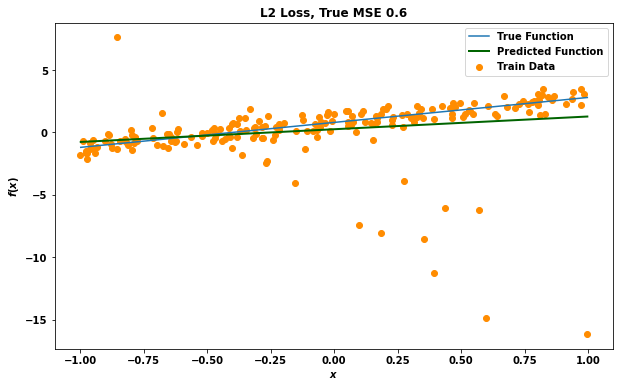

In [13]:
from sklearn.linear_model import Ridge

# TODO: Train a linear model with ridge regression and plot the result.
#       Don't forget to set fit_intercept=False
rr = Ridge(alpha=0.0001, fit_intercept=False)
### begin outliers_l2 ###
rr.fit(X, y)
rr_coef = rr.coef_
print(rr_coef)
plot_regression(X, y, w_true, rr, X_test, 'L2 Loss')
### end outliers_l2 ###

### L1 Loss
In order to solve the optimization problem with L1 loss we must use an iterative solver. `sklearn` provides a class which uses SGD to solve regression problems with several possible losses in `SGDRegressor`. **Use `SGDRegressor` with the `epsilon_insensitive` loss and `epsilon=0` to learn coefficients with the L1 loss** $L(\mathbf{X},\mathbf{y},\mathbf{w}) = |\mathbf{X}\mathbf{w} - \mathbf{y}|_1$. **Plot the result with `plot_regression`.**

SGDRegressor(epsilon=0.0, fit_intercept=False, loss='epsilon_insensitive')

[0.76260781 1.79392675]


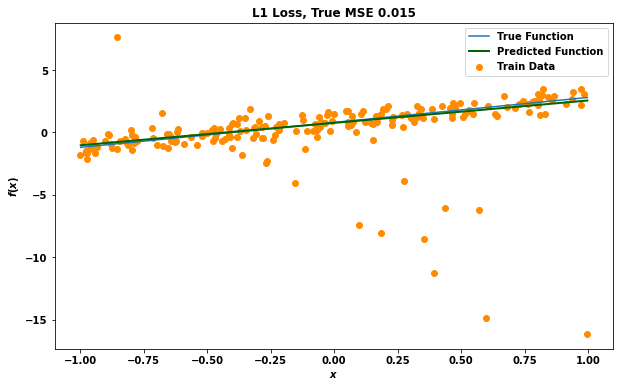

In [14]:
from sklearn.linear_model import SGDRegressor

# TODO: Train a linear model with an L1 loss and plot the result.
#       Don't forget to set fit_intercept=False.
### begin outliers_l1 ###
sgdr = SGDRegressor(loss='epsilon_insensitive', penalty='l2', alpha=0.0001, epsilon=0.0, fit_intercept=False)
sgdr.fit(X, y)
sgd_coef = sgdr.coef_
print(sgd_coef)
plot_regression(X, y, w_true, sgdr, X_test, 'L1 Loss')
### end outliers_l1 ###

### Huber Loss
The Huber loss function is a hybrid of L1 and L2 losses.
$$L_{Huber}(f(x), y, \delta) = \begin{cases} \frac{1}{2}|f(x) - y|^2, & |f(x) - y| \leq \delta \\ \delta|f(x) - y| - \frac{1}{2} \delta^2, & \text{otherwise} \end{cases} $$
The L2 loss is an ubiased estimator of the mean, and the L1 loss is an ubiased estimator of the median, so the Huber loss attempts to maintain a good estimate of the mean while reducing sensitivity to outliers. $\delta$ is a hyperparameter which represents how large the residual must be before a sample is considered an outlier. The Huber loss can also be modified for use in classification, but we won't ask you to use it here.

`sklearn` includes a regression class specifically for the Huber loss in `HuberRegressor`. `sklearn`'s implementation uses a form that is invariant with scalings of $\mathbf{X}$ and $\mathbf{y}$, so you will have to tune the hyperparameter `epsilon` in your code. See the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html) for more details.

**Use `HuberRegressor` to train a linear model with the Huber loss and plot the result with `plot_regression`.**

HuberRegressor(epsilon=1.2, fit_intercept=False)

[0.76265403 1.95502347]


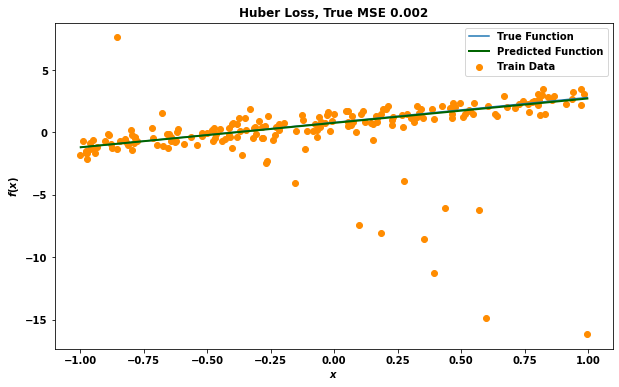

In [15]:
from sklearn.linear_model import HuberRegressor

# TODO: Train a linear model with an Huber loss and plot the result.
#       Don't forget to set fit_intercept=False.
### begin outliers_huber ###
hr = HuberRegressor(epsilon=1.2, alpha=0.0001, fit_intercept=False)
hr.fit(X, y)
h_coef = hr.coef_
print(h_coef)
plot_regression(X, y, w_true, hr, X_test, 'Huber Loss')
### end outliers_huber ###

## Exponential Model with Multiplicative Input Noise
Here we have an exponential model, but instead of additive output observation noise like you are used to the noise is multiplicative and applied to the input. In other words, instead of corrupted $y$ values we observe corrupted $x$ values. The $y$s we observe actually came from different $x$ values than we see in the training data.
$$y = e^{zx},\, z\sim {U}[1-\epsilon, 1+\epsilon]$$
We will attempt to learn this function with a polynomial model of degree $p$.
$$\hat{f}(x) = w_0 + \sum_{i=1}^p w_i x^i$$
Using the Taylor expansion of $e^x$ and $p=10$ we could achieve a test MSE of $\approx 12$ (this value may fluctuate slightly depending on the exact test points chosen).

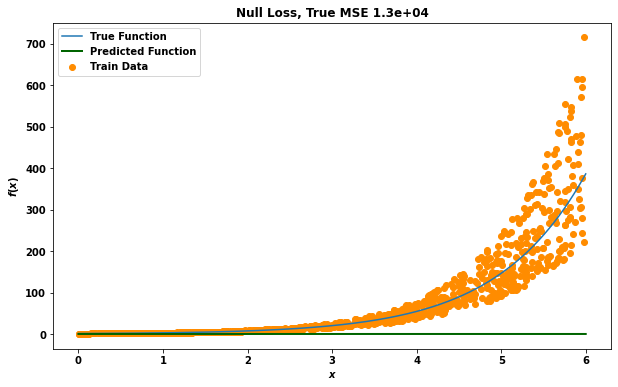

In [16]:
N = 1000
p = 10
x_max = 6
w_true = np.ones(p + 1)
X = np.ones((N, p + 1))
X[:, 1] = np.sort(np.random.uniform(0, x_max, N))
X_test = np.ones((N * 10, p + 1))
X_test[:, 1] = np.sort(np.random.uniform(0, x_max, N * 10))
for i in range(2, p + 1):
    X[:, i] = X[:, 1] ** i
    X_test[:, i] = X_test[:, 1] ** i
    w_true[i] /= np.math.factorial(i)
epsilon = 0.1
y = np.exp(X[:, 1] * np.random.uniform(1 - epsilon, 1 + epsilon, N))

plot_regression(X, y, w_true, None, X_test)

In [17]:
# Best possible approximation
print("MSE for Taylor expansion:", np.mean((np.exp(X_test[:,1]) - X_test @ w_true) **2))

MSE for Taylor expansion: 11.732846230881039


## (e)
**Train models to fit this data using $L1$, $L2$, and Huber losses. Plot the results and report the test errors.**

You may have to adjust your hyperparameters significantly relative to the model with outliers, and not every loss function may produce a reasonable model regardless of hyperparameters.

### L2 Loss

/Users/jsanz/.venvs/cs189/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.51084e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Ridge(alpha=0.01, fit_intercept=False)

[ 5.52232930e-01  4.35050888e+00 -6.45296750e-01 -1.37654010e+01
  2.24357073e+01 -1.45139887e+01  4.72335212e+00 -7.68539914e-01
  4.79244102e-02  1.47789286e-03 -2.21778424e-04]


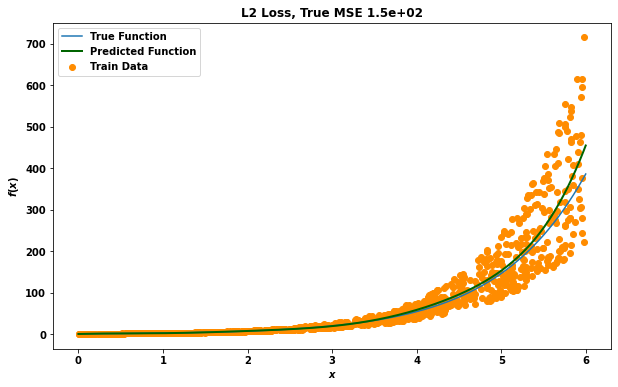

In [18]:
### begin multiplicative_l2 ###
rr = Ridge(alpha=.01, fit_intercept=False)
rr.fit(X, y)
rr_coef = rr.coef_
print(rr_coef)
plot_regression(X, y, w_true, rr, X_test, 'L2 Loss')
### end multiplicative_l2 ###

### L1 Loss

It turns out that, even though this is a convex problem, `sklearn`'s optimizer does a very poor job on this problem with an $L1$ loss. This is another example of why you should not blindly trust library implementations because they may behave in unexpected ways or fail in unexpected situations. We have given you the code we used to achieve a 'reasonable' result below. Using parameters similar to the outliers dataset gave nonsensical results with predictions on the order of $10^{11}$.

SGDRegressor(alpha=1, epsilon=0.0, eta0=7e-12, fit_intercept=False,
             loss='epsilon_insensitive')

[ 2.24923013e-08  4.84338720e-08  1.36636463e-07  4.29459978e-07
  1.42049918e-06  4.79091304e-06  1.60527956e-05  5.17345116e-05
  1.50964094e-04  3.32121542e-04 -5.78808581e-05]


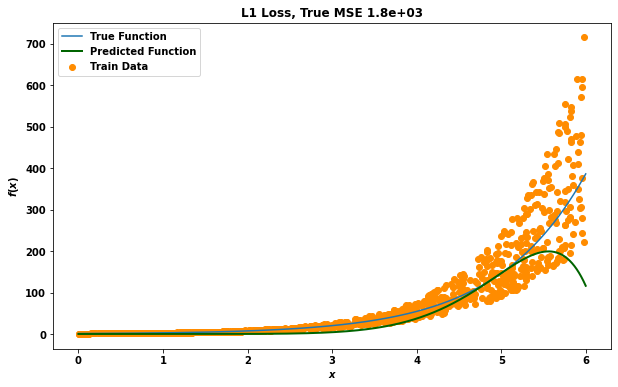

In [19]:
sgdr = SGDRegressor(loss='epsilon_insensitive', penalty='l2', alpha=1, epsilon=0.0, fit_intercept=False, 
                    eta0=7e-12)
sgdr.fit(X, y)
sgd_coef = sgdr.coef_
print(sgd_coef)
plot_regression(X, y, w_true, sgdr, X_test, 'L1 Loss')

### Huber Loss

HuberRegressor(alpha=0.01, epsilon=5, fit_intercept=False)

[ 3.93655327e-06  9.40252222e-06  2.58869047e-05  7.55108437e-05
  2.22991959e-04  6.40862928e-04  1.70449753e-03  3.82483360e-03
  5.51918237e-03 -2.27278147e-03  2.14819853e-04]


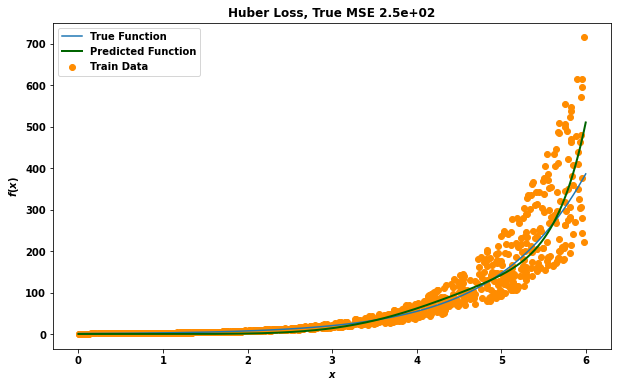

In [20]:
### begin multiplicative_huber ###
hr = HuberRegressor(epsilon=5, alpha=0.01, fit_intercept=False)
hr.fit(X, y)
h_coef = hr.coef_
print(h_coef)
plot_regression(X, y, w_true, hr, X_test, 'Huber Loss')
### end multiplicative_huber ###

## (f) Log Relative Loss
Since the function we are trying to learn is exponential, a natural modification to the regression problem is to use $\log y$ as the regression target instead of $y$. The plot below shows what the target data looks like when log-transformed. This seems like a much easier regression problem to solve than the original one!

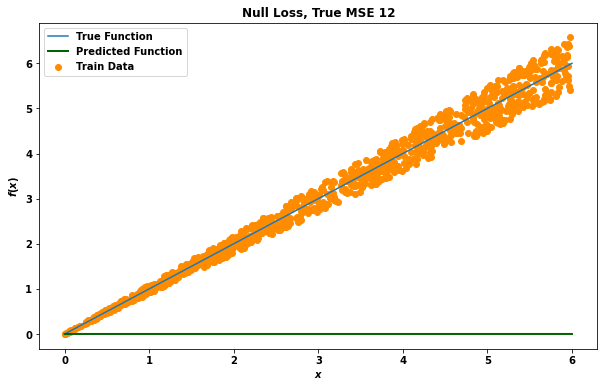

In [21]:
# Plot of the log-transformed regression problem
plot_regression(X, np.log(y), np.array([0,1]+[0]*9), None, X_test)

**Using `sklearn`'s `TransformedTargetRegressor` meta-class, train on log-transformed $y$ values, plot the result, and report the test error.**

`TransformedTargetRegressor` takes three inputs:
- `regressor`: a regressor object, e.g. `Ridge(alpha=1, fit_intercept=False)`
- `func`: the transformation to apply, e.g. `lambda x: np.power(x, 2)`
- `inverse_func`: the inverse transformation to apply to predictions, e.g. `np.sqrt`

/Users/jsanz/.venvs/cs189/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.65893e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=Ridge(fit_intercept=False))

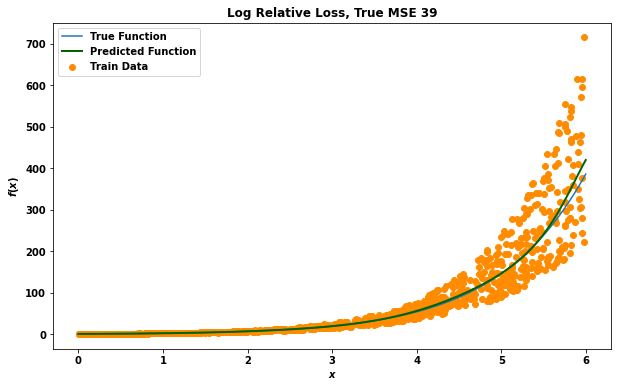

In [22]:
from sklearn.compose import TransformedTargetRegressor

# TODO: Use the TransformedTargetRegressor to train a Ridge model on log-
#       transformed targets.
#       Don't forget to set fit_intercept=False.
### begin log_loss ###
lrr = TransformedTargetRegressor(regressor=Ridge(alpha=1.0, fit_intercept=False),
                                 func=np.log,
                                 inverse_func=np.exp)
lrr.fit(X, y)
plot_regression(X, y, w_true, lrr, X_test, 'Log Relative Loss')
### end log_loss ###